Code testing for https://github.com/pymc-devs/pymc3/pull/2986

In [1]:
import numpy as np
import pymc3 as pm
import pymc3.distributions.transforms as tr
import theano.tensor as tt
from theano.scan_module import until
import theano
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Polar transformation
    

In [2]:
# Polar to Cartesian
def backward(y):
    # y = [r, theta]
    x = tt.zeros(y.shape)
    x = tt.inc_subtensor(x[0], y[0]*tt.cos(y[1]))
    x = tt.inc_subtensor(x[1], y[0]*tt.sin(y[1]))
    return x

def forward(x):
    # y = [r, theta]
    y = tt.zeros(x.shape)
    y = tt.inc_subtensor(y[0], tt.sqrt(tt.square(x[0]) + tt.square(x[1])))
    if y[0] != 0:
        if x[1] < 0:
            theta = -tt.arccos(x[0]/y[0])
        else:
            theta = tt.arccos(x[0]/y[0])
    y = tt.inc_subtensor(y[1], theta)
    return y

In [3]:
y = tt.vector('polar')
y.tag.test_value=np.asarray([1., np.pi/2])

In [4]:
f_inv = backward(y)
J, _ = theano.scan(lambda i, f, x: tt.grad(f[i], x),
                       sequences=tt.arange(f_inv.shape[0]),
                       non_sequences=[f_inv, y])

In [5]:
Jacob_f1 = theano.function([y], J)

In [6]:
Jacob_f1(np.asarray([1., np.pi/2]))

array([[ 6.123234e-17, -1.000000e+00],
       [ 1.000000e+00,  6.123234e-17]])

In [7]:
J2 = pm.theanof.jacobian(f_inv, [y])
Jacob_f2 = theano.function([y], J2)
Jacob_f2(np.asarray([1., np.pi/2]))

array([[ 6.123234e-17, -1.000000e+00],
       [ 1.000000e+00,  6.123234e-17]])

In [8]:
%timeit Jacob_f1(np.asarray([1., np.pi/2]))
%timeit Jacob_f2(np.asarray([1., np.pi/2]))

88.6 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
91.4 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
class VectorTransform(tr.Transform): 
 
    def jacobian_det(self, x): 
        f_inv = self.backward(x) 
        J, _ = theano.scan(lambda i, f, x: tt.grad(f[i], x), 
                           sequences=tt.arange(f_inv.shape[0]), 
                           non_sequences=[f_inv, x]) 
        return tt.log(tt.abs_(tt.nlinalg.det(J))) 

In [10]:
class Nealfun(VectorTransform):
    name = "Neal_funnel"

    def backward(self, y):
        x = tt.zeros(y.shape)
        x = tt.inc_subtensor(x[0], y[0] / 3.)
        x = tt.inc_subtensor(x[1:], y[1:] / tt.exp(y[0] / 2))
        return x

    def forward(self, x):
        y = tt.zeros(x.shape)
        y = tt.inc_subtensor(y[0], x[0] * 3.)
        y = tt.inc_subtensor(y[1:], tt.exp(x[0] * 3. / 2) * x[1:])
        return y

In [11]:
y = tt.vector('y')
y.tag.test_value = np.zeros(101)

In [12]:
nealfun = Nealfun()
f_inv = nealfun.backward(y)

J1, _ = theano.scan(lambda i, f, x: tt.grad(f[i], x),
                       sequences=tt.arange(f_inv.shape[0]),
                       non_sequences=[f_inv, y])
Jacob_f1 = theano.function([y], J1)

J2 = pm.theanof.jacobian(f_inv, [y])
Jacob_f2 = theano.function([y], J2)

In [13]:
%timeit Jacob_f1(np.zeros(101))
%timeit Jacob_f2(np.zeros(101))

1.23 ms ± 57.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.23 ms ± 44.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Copulas
Background reading http://twiecki.github.io/blog/2018/05/03/copulas/  
More information https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Copula.ipynb

In [14]:
import scipy.stats as st
norm = st.norm()

In [15]:
def norm_cdf(x):
    return x_unif


def copulas_forward_func(nsample, cov, marg1_ppf, marg2_ppf):
    mvnorm = st.multivariate_normal(mean=[0, 0], cov=cov)
    # Generate random samples from multivariate normal with correlation .5
    x = mvnorm.rvs(nsample)
    x_unif = norm.cdf(x)
    x_trans = np.vstack([marg1_ppf(x_unif[:, 0]), marg2_ppf(x_unif[:, 1])]).T
    return x_trans, x_unif, x

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


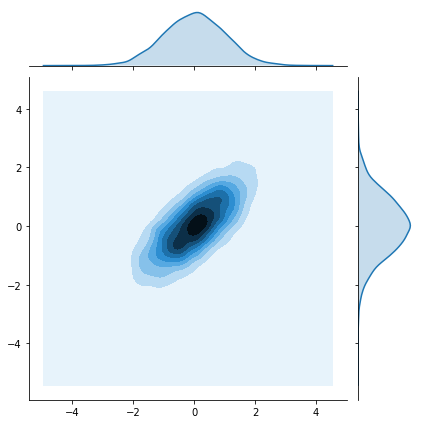

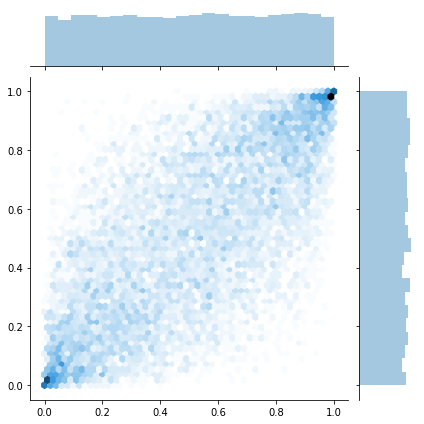

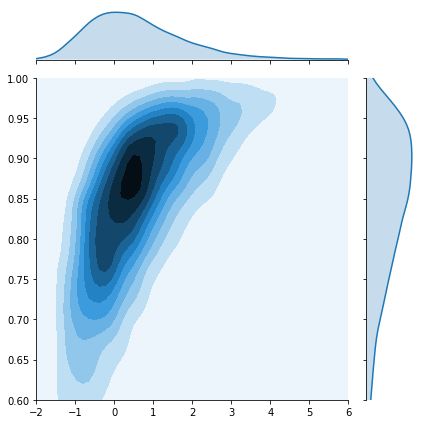

In [16]:
cov = np.asarray([[1., 0.725], [0.725, 1.]])
marg1_ppf = st.gumbel_r().ppf
marg2_ppf = st.beta(a=10, b=2).ppf
x_trans, x_unif, x = copulas_forward_func(10000, cov, marg1_ppf, marg2_ppf)

sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None)
sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex',
              stat_func=None, joint_kws=dict(gridsize=50))
sns.jointplot(x_trans[:, 0], x_trans[:, 1], kind='kde',
              stat_func=None, xlim=(-2, 6), ylim=(.6, 1.0),)
plt.tight_layout()

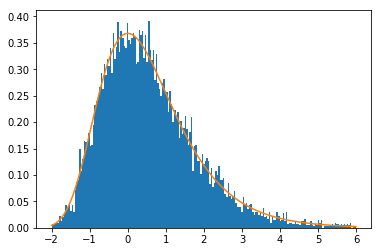

In [17]:
xrange = np.linspace(-2, 6, 200)
plt.hist(x_trans[:, 0], xrange, density='pdf')
plt.plot(xrange, st.gumbel_r.pdf(xrange));

In [18]:
def gumbel_cdf(value, mu, beta):
    return tt.exp(-tt.exp(-(value-mu)/beta))

Beta CDF

In [19]:
from theano.scan_module import until

In [20]:
max_iter=200
value_, a, b = x_trans[:, 1], 10., 2.
value = theano.shared(np.reshape(value_, (1,len(value_))))

EPS = 3.0e-7
qab = a + b
qap = a + 1.0
qam = a - 1.0

def _step(i, az, bm, am, bz):

    tem = i + i
    d = i * (b - i) * value / ((qam + tem) * (a + tem))
    d =- (a + i) * i * value / ((qap + tem) * (a + tem))

    ap = az + d * am
    bp = bz + d * bm

    app = ap + d * az
    bpp = bp + d * bz

    aold = az

    am = ap / bpp
    bm = bp / bpp
    az = app / bpp

    bz = tt.ones_like(bz)

    return (az, bm, am, bz), until(tt.sum(tt.lt(tt.abs_(az - aold), (EPS * tt.abs_(az)))))

(az, bm, am, bz), _ = theano.scan(_step,
            sequences=[tt.arange(1, max_iter)],
            outputs_info=[tt.ones_like(value),
                          tt.ones_like(value), 
                          tt.ones_like(value), 
                          1. - qab * value / qap])

In [21]:
def cont_fraction_beta(value_, a, b, max_iter=500):
    '''Evaluates the continued fraction form of the incomplete Beta function.
    Derived from implementation by Ali Shoaib (https://goo.gl/HxjIJx).
    '''

    EPS = 1.0e-20
    qab = a + b
    qap = a + 1.0
    qam = a - 1.0
    value = theano.shared(value_)

    def _step(i, az, bm, am, bz):

        tem = i + i
        d = i * (b - i) * value / ((qam + tem) * (a + tem))
        d = - (a + i) * i * value / ((qap + tem) * (a + tem))

        ap = az + d * am
        bp = bz + d * bm

        app = ap + d * az
        bpp = bp + d * bz

        aold = az

        am = ap / bpp
        bm = bp / bpp
        az = app / bpp

        bz = tt.ones_like(bz)

        return (az, bm, am, bz), until(tt.sum(tt.lt(tt.abs_(az - aold), (EPS * tt.abs_(az)))))

    (az, bm, am, bz), _ = theano.scan(_step,
                                      sequences=[tt.arange(1, max_iter)],
                                      outputs_info=[tt.ones_like(value),
                                                    tt.ones_like(value),
                                                    tt.ones_like(value),
                                                    1. - qab * value / qap])

    return az[-1]


def beta_cdf(value, a, b):
    log_beta = tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)
    log_beta += a * tt.log(value) + b * tt.log(1 - value)
    cdf = tt.switch(
        tt.lt(value, (a + 1) / (a + b + 2)),
        tt.exp(log_beta) * cont_fraction_beta(value, a, b) / a,
        1. - tt.exp(log_beta) * cont_fraction_beta(1. - value, b, a) / b
    )
    return cdf

In [22]:
def normal_ppf(value):
    return -np.sqrt(2.) * tt.erfcinv(2. * value)

In [23]:
functmp = theano.function([],
                          tt.stack([gumbel_cdf(x_trans[:, 0], 0., 1.),
                                    beta_cdf(x_trans[:, 1], 10., 2.)]).T
                          )
x_ = functmp()
x_

array([[0.68787952, 0.55857696],
       [0.86436815, 0.92398402],
       [0.4552406 , 0.39302856],
       ...,
       [0.90376206, 0.32358112],
       [0.9529977 , 0.88148983],
       [0.38198762, 0.24042976]])

In [24]:
x_unif

array([[0.68787952, 0.60569206],
       [0.86436815, 0.92458601],
       [0.4552406 , 0.50441497],
       ...,
       [0.90376206, 0.21251765],
       [0.9529977 , 0.88316382],
       [0.38198762, 0.43831509]])

In [25]:
np.sum(~np.isfinite(x_))

0

In [26]:
with pm.Model() as model:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r',lower=-1, upper=1)

    cov = pm.Deterministic('cov', 
                           tt.stacklists([[1., r],
                                          [r, 1.]]))
    a = pm.HalfNormal('alpha', 5., testval=10.)
    b = pm.HalfNormal('beta', 2.5, testval=2.)
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)

    tr_func = normal_ppf(
        tt.stack([gumbel_cdf(x_trans[:, 0], loc, scale),
                  beta_cdf(x_trans[:, 1], a, b)]).T
    )
    pm.MvNormal('obs', np.zeros(2), cov=cov, observed=tr_func)
    pm.Gumbel('marg0', loc, scale, observed=x_trans[:, 0])
    pm.Beta('marg1', a, b, observed=x_trans[:, 1])

ValueError: array must not contain infs or NaNs

The beta CDF does not quite work - use another distribution instead

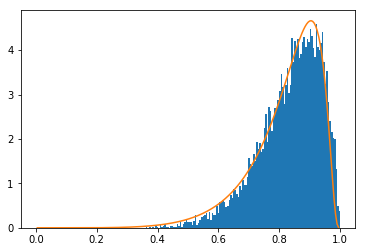

In [27]:
from scipy.special import logit
xrange = np.linspace(0, 1, 200)
plt.hist(x_trans[:, 1], xrange, density='pdf')
logitnormpdf = st.norm.pdf(logit(xrange), loc=1.725, scale=.8) * 1/(xrange * (1-xrange))
plt.plot(xrange, logitnormpdf);

In [28]:
def logitnorm_cdf(value, mu, sd):
    return .5 + .5*(tt.erf((pm.math.logit(value)-mu)/(np.sqrt(2)*sd)))

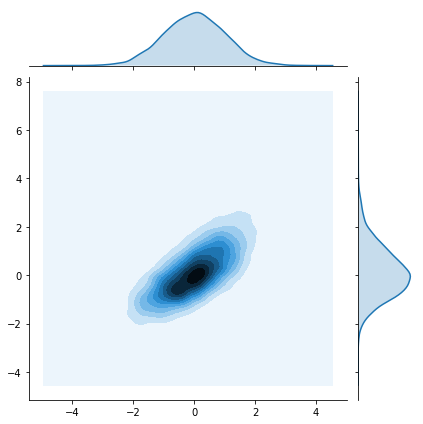

In [29]:
tr_func = normal_ppf(
    tt.stack([gumbel_cdf(x_trans[:, 0], 0., 1.),
              logitnorm_cdf(x_trans[:, 1], 1.725, .8)]).T
)
functmp = theano.function([], tr_func)
x_ = functmp()
sns.jointplot(x_[:, 0], x_[:, 1], kind='kde', stat_func=None);

In [30]:
np.sum(~np.isfinite(x_[:, 1]))

0

In [31]:
with pm.Model() as model:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r',lower=-1, upper=1)

    cov = pm.Deterministic('cov', 
                           tt.stacklists([[1., r],
                                          [r, 1.]]))
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)
    mu = pm.Normal('mu', 1., 1., testval=1.725)
    sd = pm.HalfNormal('sd', .5, testval=.8)

    tr_func = normal_ppf(
        tt.stack([gumbel_cdf(x_trans[:, 0], loc, scale),
                  logitnorm_cdf(x_trans[:, 1], mu, sd)]).T
    )

    pm.MvNormal('obs', np.zeros(2), cov=cov, observed=tr_func)
    pm.Gumbel('marg0', loc, scale, observed=x_trans[:, 0])
    pm.LogitNormal('marg1', mu, sd, observed=x_trans[:, 1])

In [32]:
with model:
    map1 = pm.find_MAP()
map1

logp = -27,020, ||grad|| = 827.37: 100%|██████████| 19/19 [00:00<00:00, 225.73it/s]  


{'cov': array([[1.        , 0.89384833],
        [0.89384833, 1.        ]]),
 'loc': array(-0.16072809),
 'mu': array(1.84011234),
 'r': array(0.89384833),
 'r_interval__': array(2.88149726),
 'scale': array(1.68237827),
 'scale_log__': array(0.52020843),
 'sd': array(1.43276981),
 'sd_log__': array(0.3596095)}

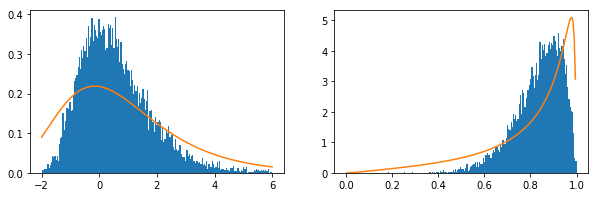

In [33]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
x0 = np.linspace(-2, 6, 200)
ax[0].hist(x_trans[:, 0], x0, density='pdf')
ax[0].plot(x0, st.gumbel_r.pdf(x0, loc=map1['loc'], scale=map1['scale']))

x1 = np.linspace(0, 1, 200)
ax[1].hist(x_trans[:, 1], x1, density='pdf')
logitnormpdf = st.norm.pdf(logit(x1), loc=map1['mu'], scale=map1['sd']) * 1/(x1 * (1-x1))
ax[1].plot(x1, logitnormpdf);

In [60]:
with pm.Model() as model_marg:
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)
    mu = pm.Normal('mu', 1., 1., testval=1.725)
    sd = pm.HalfNormal('sd', .5, testval=.8)

    pm.Gumbel('marg0', loc, scale, observed=x_trans[:, 0])
    pm.LogitNormal('marg1', mu, sd, observed=x_trans[:, 1])
    map_ = pm.find_MAP()

map_

logp = -6,550.6, ||grad|| = 2,666.5: 100%|██████████| 9/9 [00:00<00:00, 1126.19it/s]


{'loc': array(0.01353247),
 'mu': array(1.84158276),
 'scale': array(1.00474317),
 'scale_log__': array(0.00473196),
 'sd': array(0.8664451),
 'sd_log__': array(-0.14335653)}

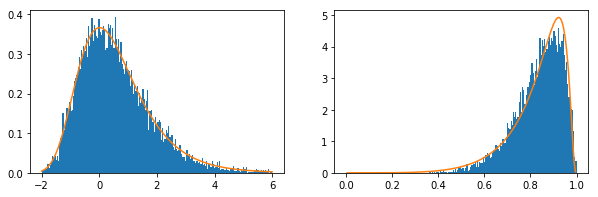

In [35]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
x0 = np.linspace(-2, 6, 200)
ax[0].hist(x_trans[:, 0], x0, density='pdf')
ax[0].plot(x0, st.gumbel_r.pdf(x0, loc=map_['loc'], scale=map_['scale']))

x1 = np.linspace(0, 1, 200)
ax[1].hist(x_trans[:, 1], x1, density='pdf')
logitnormpdf = st.norm.pdf(logit(x1), loc=map_['mu'], scale=map_['sd']) * 1/(x1 * (1-x1))
ax[1].plot(x1, logitnormpdf);

In [36]:
from pymc3.theanof import gradient

def jacobian_det(f_inv_x, x):
    grad = tt.reshape(gradient(tt.sum(f_inv_x), [x]), x.shape)
    return tt.log(tt.abs_(grad))

In [62]:
xt_0 = theano.shared(x_trans[:, 0])
xt_1 = theano.shared(x_trans[:, 1])

with pm.Model() as model2:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r',lower=-1, upper=1)

    cov = pm.Deterministic('cov', 
                           tt.stacklists([[1., r],
                                          [r, 1.]]))
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)
    mu = pm.Normal('mu', 1., .5, testval=1.725)
    sd = pm.HalfNormal('sd', .5, testval=.8)

    tr_func = normal_ppf(
        tt.stack([gumbel_cdf(xt_0, loc, scale),
                  logitnorm_cdf(xt_1, mu, sd)]).T
    )

    pm.MvNormal('obs', np.zeros(2), cov=cov, observed=tr_func)
    pm.Potential('jacob_det0', jacobian_det(normal_ppf(gumbel_cdf(xt_0, loc, scale)), xt_0))
    pm.Potential('jacob_det1', jacobian_det(normal_ppf(logitnorm_cdf(xt_1, mu, sd)), xt_1))
    map_ = pm.find_MAP()

_, ax = plt.subplots(1, 2, figsize=(10, 3))
x0 = np.linspace(-2, 6, 200)
ax[0].hist(x_trans[:, 0], x0, density='pdf')
ax[0].plot(x0, st.gumbel_r.pdf(x0, loc=map_['loc'], scale=map_['scale']))

x1 = np.linspace(0, 1, 200)
ax[1].hist(x_trans[:, 1], x1, density='pdf')
logitnormpdf = st.norm.pdf(logit(x1), loc=map_['mu'], scale=map_['sd']) * 1/(x1 * (1-x1))
ax[1].plot(x1, logitnormpdf);

logp = -6,551.4, ||grad|| = 4,722.5:   0%|          | 3/5000 [00:00<01:18, 63.70it/s]


ValueError: array must not contain infs or NaNs
Apply node that caused the error: Solve{A_structure='lower_triangular', lower=False, overwrite_A=False, overwrite_b=False}(Elemwise{Switch}[(0, 1)].0, Elemwise{Mul}[(0, 1)].0)
Toposort index: 48
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(2, 2), (2, 10000)]
Inputs strides: [(8, 16), (80000, 8)]
Inputs values: [array([[1.        , 0.        ],
       [0.76609949, 0.642722  ]]), 'not shown']
Outputs clients: [[InplaceDimShuffle{1,0}(Solve{A_structure='lower_triangular', lower=False, overwrite_A=False, overwrite_b=False}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/laoj/Documents/Github/pymc3/pymc3/distributions/distribution.py", line 37, in __new__
    return model.Var(name, dist, data, total_size)
  File "/home/laoj/Documents/Github/pymc3/pymc3/model.py", line 831, in Var
    total_size=total_size, model=self)
  File "/home/laoj/Documents/Github/pymc3/pymc3/model.py", line 1312, in __init__
    self.logp_nojac_unscaledt = distribution.logp_nojac(data)
  File "/home/laoj/Documents/Github/pymc3/pymc3/distributions/distribution.py", line 106, in logp_nojac
    return self.logp(*args, **kwargs)
  File "/home/laoj/Documents/Github/pymc3/pymc3/distributions/multivariate.py", line 273, in logp
    quaddist, logdet, ok = self._quaddist(value)
  File "/home/laoj/Documents/Github/pymc3/pymc3/distributions/multivariate.py", line 96, in _quaddist
    dist, logdet, ok = self._quaddist_cov(delta)
  File "/home/laoj/Documents/Github/pymc3/pymc3/distributions/multivariate.py", line 123, in _quaddist_cov
    return self._quaddist_chol(delta)
  File "/home/laoj/Documents/Github/pymc3/pymc3/distributions/multivariate.py", line 117, in _quaddist_chol
    delta_trans = self.solve_lower(chol_cov, delta.T).T

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

Kumaraswamy distribution

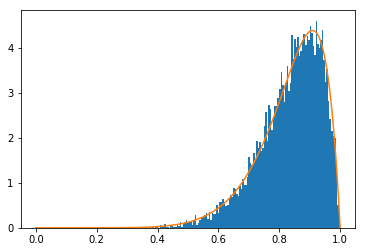

In [42]:
from scipy.special import logit
xrange = np.linspace(0, 1, 200)
plt.hist(x_trans[:, 1], xrange, density='pdf')
Kumaraswamypdf = lambda x, a, b: a*b*np.power(x, a-1)*np.power(1-np.power(x, a), b-1)
plt.plot(xrange, Kumaraswamypdf(xrange, 8, 2));

In [43]:
def Kumaraswamy_cdf(value, a, b):
    return 1 - tt.pow(1 - tt.pow(value, a), b)

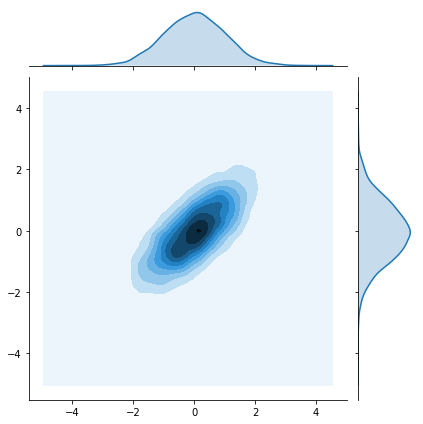

In [44]:
tr_func = normal_ppf(
    tt.stack([gumbel_cdf(x_trans[:, 0], 0., 1.),
              Kumaraswamy_cdf(x_trans[:, 1], 8, 2)]).T
)
functmp = theano.function([], tr_func)
x_ = functmp()
sns.jointplot(x_[:, 0], x_[:, 1], kind='kde', stat_func=None);

In [45]:
np.sum(~np.isfinite(x_[:, 1]))

0

In [49]:
with pm.Model() as model_marg:
    a = pm.HalfNormal('alpha', 5., testval=10.)
    b = pm.HalfNormal('beta', 2.5, testval=2.)
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)

    pm.Gumbel('marg0', loc, scale, observed=x_trans[:, 0])
    pm.Kumaraswamy('marg1', a, b, observed=x_trans[:, 1])
    map_ = pm.find_MAP()

logp = -6,119.5, ||grad|| = 0.0012194: 100%|██████████| 12/12 [00:00<00:00, 440.00it/s]  


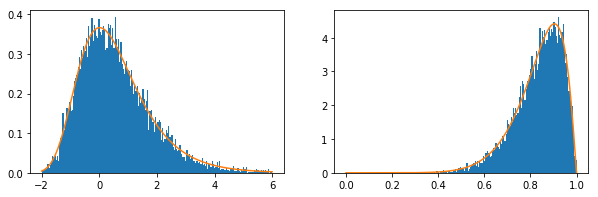

In [50]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
x0 = np.linspace(-2, 6, 200)
ax[0].hist(x_trans[:, 0], x0, density='pdf')
ax[0].plot(x0, st.gumbel_r.pdf(x0, loc=map_['loc'], scale=map_['scale']))

x1 = np.linspace(0, 1, 200)
ax[1].hist(x_trans[:, 1], x1, density='pdf')
ax[1].plot(x1, Kumaraswamypdf(x1, map_['alpha'], map_['beta']));

logp = -2,456.2, ||grad|| = 714.74: 100%|██████████| 19/19 [00:00<00:00, 84.15it/s]  


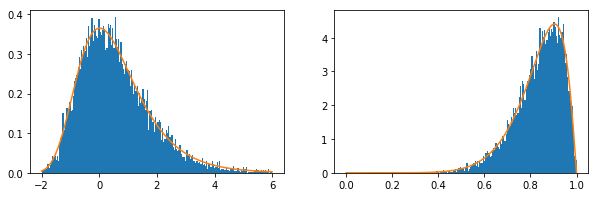

In [54]:
with pm.Model() as model2:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r',lower=-1, upper=1)

    cov = pm.Deterministic('cov', 
                           tt.stacklists([[1., r],
                                          [r, 1.]]))

    a = pm.HalfNormal('alpha', 5.)
    b = pm.HalfNormal('beta', 2.5)
    loc = pm.Normal('loc', 0., 5.)
    scale = pm.HalfNormal('scale', 2.5)

    tr_func = normal_ppf(
        tt.stack([gumbel_cdf(xt_0, loc, scale),
                  Kumaraswamy_cdf(xt_1, a, b)]).T
    )

    pm.MvNormal('obs', np.zeros(2), cov=cov, observed=tr_func)
    pm.Potential('jacob_det0', jacobian_det(normal_ppf(gumbel_cdf(xt_0, loc, scale)), xt_0))
    pm.Potential('jacob_det1', jacobian_det(normal_ppf(Kumaraswamy_cdf(xt_1, a, b)), xt_1))
    map_ = pm.find_MAP()

_, ax = plt.subplots(1, 2, figsize=(10, 3))
x0 = np.linspace(-2, 6, 200)
ax[0].hist(x_trans[:, 0], x0, density='pdf')
ax[0].plot(x0, st.gumbel_r.pdf(x0, loc=map_['loc'], scale=map_['scale']))

x1 = np.linspace(0, 1, 200)
ax[1].hist(x_trans[:, 1], x1, density='pdf')
ax[1].plot(x1, Kumaraswamypdf(x1, map_['alpha'], map_['beta']));

In [55]:
map_

{'alpha': array(8.17165941),
 'alpha_log__': array(2.100672),
 'beta': array(2.11837898),
 'beta_log__': array(0.75065117),
 'cov': array([[1.        , 0.72592234],
        [0.72592234, 1.        ]]),
 'loc': array(0.0141455),
 'r': array(0.72592234),
 'r_interval__': array(1.8401054),
 'scale': array(1.00852072),
 'scale_log__': array(0.00848463)}